# Projet ADEME : Recherche opérationnelle

## Préparation de l'environnement

### Importation des librairies

In [35]:
# Importer les bibliothèques nécessaires
import pulp
import time
import random
import itertools
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

### Fonctions générales

- **generate_graph** : Génère un graphe aléatoire complet de $n$ sommets avec des poids de ditance et de temps sur les arrêtes. Il resteint les arrêtes en leur donnant un poids de 999 selon une certaine probabilité (1%).
- **draw_graph** : Affiche le graphe $G$ avec les solutions de routes si elles existent.
- **print_solution** : Affiche la distance totale et le temps maximum des camions ainsi qu'un tableau avec la distance, le temps et la tournée de chaque camion.
- **plot_graph** : Affiche les graphiques de statistique

In [ ]:
def generate_graph(N, restriction_probability=0.1, distance_range=(1, 100), time_range=(1, 60)):
    # Crée un graphe complet avec n sommets
    G = nx.complete_graph(N)

    # Parcourt toutes les arêtes du graphe
    for u, v in G.edges():
        # Pour chaque arête, on attribue une distance et un temps
        # Avec une probabilité 'restriction_probability', on met une valeur élevée (999) pour simuler une contrainte
        G[u][v]['distance'] = 999 if random.random() < restriction_probability else random.randint(*distance_range)
        G[u][v]['time'] = 999 if random.random() < restriction_probability else random.randint(*time_range)

    return G

def draw_graph(G, routes=None, depots=[0], title="Graphe complet généré aléatoirement"):
    # Calcule les positions des nœuds pour affichage (mise en page stable grâce à seed=42)
    pos = nx.spring_layout(G, seed=42)

    # Prépare les étiquettes des arêtes avec distance et temps
    edge_labels = {(u, v): f"D:{G.edges[u, v]['distance']}, T:{G.edges[u, v]['time']}" for u, v in G.edges}

    plt.figure(figsize=(8, 5))
    plt.title(title)

    # Affiche les nœuds : verts pour les dépôts, bleus sinon
    nx.draw_networkx_nodes(G, pos, node_color=['lightgreen' if n in depots else 'lightblue' for n in G.nodes], node_size=250)
    # Affiche les étiquettes des nœuds (identifiants)
    nx.draw_networkx_labels(G, pos, font_size=7)
    # Affiche les arêtes en gris clair par défaut
    nx.draw_networkx_edges(G, pos, alpha=0.2)

    # Si des routes sont fournies, on les dessine en couleurs plus visibles
    if routes:
        line_color = ["red", "blue", "green", "orange", "purple"]
        for k, edges in enumerate(routes):
            nx.draw_networkx_edges(G, pos, edgelist=edges, width=1.5, edge_color=line_color[k % len(line_color)])

    # Affiche les étiquettes des arêtes (distance et temps)
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=6)

    plt.show()

def print_solution(G, routes, depot=0):
    # Calcule les coûts globaux (somme des distances et des temps)
    solution_distance = sum(G.edges[u, v]['distance'] for edges in routes for u, v in edges)
    solution_time = max(sum(G.edges[u, v]['time'] for u, v in edges) for edges in routes)

    # Affiche le résumé global
    print("\n\033[1mRÉSUMÉ GLOBAL\033[0m")
    print(f"Distance totale : {solution_distance}")
    print(f"Temps max       : {solution_time}")

    # En-tête du tableau
    header = f"\n\033[1m{'Camion':<8}{'Distance':>12}{'Temps':>10}   Tournée\033[0m"
    print(header)
    print("-" * len(header))

    # Affiche le détail de chaque tournée (par camion)
    for k, edges in enumerate(routes):
        # Calcule la distance et le temps pour chaque camion
        dist = sum(G.edges[u, v]['distance'] for u, v in edges)
        time = sum(G.edges[u, v]['time'] for u, v in edges)

        # Reconstruction du chemin dans l'ordre
        path = [depot]
        remaining = edges.copy()
        while remaining:
            for idx, (i, j) in enumerate(remaining):
                if i == path[-1]:
                    path.append(j)
                    remaining.pop(idx)
                    break
                elif j == path[-1]:
                    path.append(i)
                    remaining.pop(idx)
                    break
            else:
                # Si on n'arrive pas à déterminer l'ordre du chemin, on ajoute tout ce qui reste à la suite
                path.extend([edge for pair in remaining for edge in pair])
                break

        # Affiche le chemin de la tournée sous forme lisible
        path_str = " → ".join(map(str, path))
        print(f"{k:<8}{dist:>12}{time:>10}   {path_str}")

def plot_graph(df, methods, x_col, y_col, xlabel, ylabel, title, error_col=None, with_errorbar=False):
    # Crée un graphique à partir d'un DataFrame
    plt.figure(figsize=(8, 4))
    for method in methods:
        method_data = df[df['method'] == method]
        x = method_data[x_col]
        y = method_data[y_col]
        
        # Si on utilise des barres d'erreur, on vérifie que la colonne d'erreur existe
        if with_errorbar and error_col in method_data.columns:
            yerr = method_data[error_col]
            plt.errorbar(x, y, yerr=yerr, label=method, marker='o', capsize=5)
        else:
            plt.plot(x, y, marker='o', label=method)
    
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

## Génération d'un graphe aléatoire $G$ pour le reste de la présentation

### Modification de la Seed à chaque lancement du code

In [ ]:
# Génère une graine aléatoire entre 0 et 100000
seed = random.randint(0, 100000)

# Initialise le générateur de nombres aléatoires avec cette graine
# Cela permet de reproduire exactement les mêmes résultats si on relance le programme avec la même seed
random.seed(seed)

# Affiche la seed utilisée pour pouvoir la réutiliser si besoin
print(f"Seed : {seed}")

Seed : 26013


### Graphe généré à partir de la seed

Ce graphe sera utilisé tout au long de la présentation pour comparer les différents algorithmes.

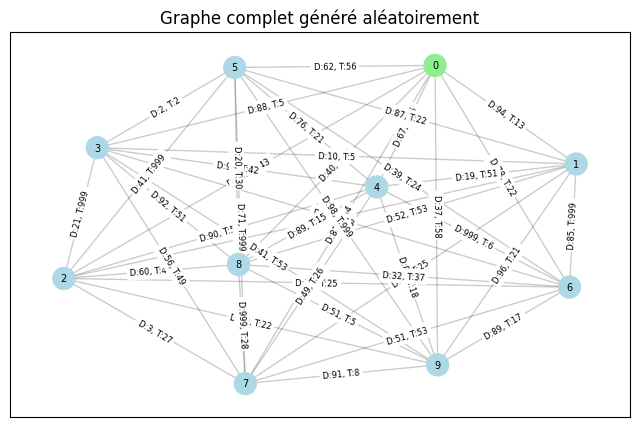

In [38]:
N = 10  # Nombre de sommets (villes ou points à visiter)
K = 2   # Nombre de camions

# Génération d'un graphe complet avec 15 sommets
# Chaque arête reçoit une distance et un temps aléatoires
G = generate_graph(N)

# Affichage du graphe généré avec les distances et temps sur les arêtes
draw_graph(G)

## Resolution du problème grâce à la **programmation linéaire**

Cet algorithme donne la solution optimale au problème en utilisant la librairie Pulp de python.

In [ ]:
def PL_VRP(G, K, depot=0):
    customers = [v for v in G.nodes if v != depot]      # Sommets à visiter
    m = len(customers)                                  # Nombre de clients
    L = m // K                                          # Nombre minimum de clients par camion
    U = L if m % K == 0 else L + 1                      # Nombre maximum de clients par camion

    arcs = [(i, j) for i in G.nodes for j in G.nodes if i != j]

    # --- Définir le problème --- #
    prob = pulp.LpProblem("Distance_VRP", pulp.LpMinimize)

    # --- Variables de décision --- #
    # x[i,j,k] = 1 si le camion k prend l'arc (i,j), 0 sinon
    # u[i,k] = Nombre de clients visités par le camion k avant le client i
    x = pulp.LpVariable.dicts("x", ((i, j, k) for (i, j) in arcs for k in range(K)), lowBound=0, upBound=1, cat="Binary")
    u = pulp.LpVariable.dicts("u", ((i, k) for i in customers for k in range(K)), lowBound=1, upBound=m, cat="Integer")

    # --- Fonction objectif : minimiser la distance totale parcourue --- #
    prob += pulp.lpSum(G.edges[i, j]["distance"] * x[(i, j, k)] for (i, j) in arcs for k in range(K))

    # --- Contraintes --- #
    # Chaque client exactement une fois
    for i in customers:
        prob += pulp.lpSum(x[(i, j, k)] for j in G.nodes if j != i for k in range(K)) == 1

    # Un départ & un retour dépôt par camion
    for k in range(K):
        prob += pulp.lpSum(x[(0, j, k)] for j in customers) == 1
        prob += pulp.lpSum(x[(i, 0, k)] for i in customers) == 1

    # Conservation du flux
    for k in range(K):
        for v in customers:
            prob += (pulp.lpSum(x[(i, v, k)] for i in G.nodes if i != v) - pulp.lpSum(x[(v, j, k)] for j in G.nodes if j != v)) == 0

    # MTZ : élimination des sous-tours
    for k in range(K):
        for i, j in itertools.permutations(customers, 2):
            prob += u[(i, k)] - u[(j, k)] + m * x[(i, j, k)] <= m - 1

    # Équilibrage (même nombre de clients ±1 par camion)
    # L = m // K, U = L + 1 si m % K != 0
    # L <= nombre de clients par camion <= U
    for k in range(K):
        prob += pulp.lpSum(x[(i, j, k)] for i in customers for j in G.nodes if j != i) >= L
        prob += pulp.lpSum(x[(i, j, k)] for i in customers for j in G.nodes if j != i) <= U

    # Résolution
    prob.solve(pulp.PULP_CBC_CMD(msg=False))

    # Récupération des arêtes sélectionnées pour chaque camion
    routes = [[] for _ in range(K)]
    for k in range(K):
        for i, j in arcs:
            if pulp.value(x[(i, j, k)]) > 0.5:
                routes[k].append((i, j))

    return routes


RÉSUMÉ GLOBAL
Distance totale : 353
Temps max       : 241

Camion      Distance     Temps   Tournée
-------------------------------------------------
0                160       150   0 → 5 → 3 → 1 → 4 → 0
1                193       241   0 → 8 → 6 → 7 → 2 → 9 → 0


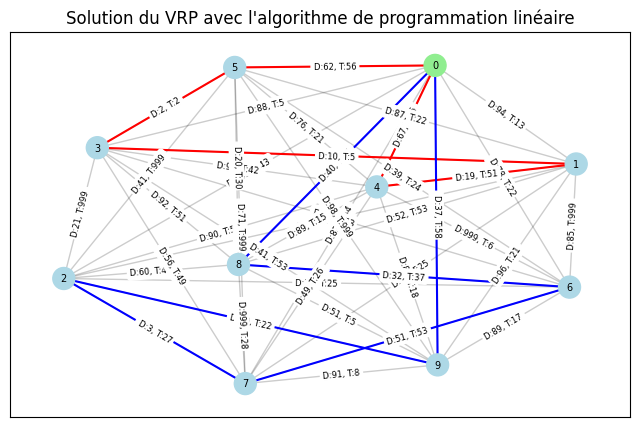

In [40]:
# Cette fonction retourne les routes optimisées et la distance totale minimale.
solution = PL_VRP(G, K)

# Pour chaque tournée, elle affiche les nœuds visités et la distance parcourue.
print_solution(G, solution)

# Affiche le graphe avec les tournées optimales visualisées
draw_graph(G, solution, title="Solution du VRP avec l'algorithme de programmation linéaire")

## Resolution du problème grâce à la **l'algorithme tabou**

Cet algorithme commence par une solution simple, puis explore des solutions voisines. À chaque étape, il choisit la meilleure solution voisine et répète cette boucle plusieurs fois, jusqu’à atteindre un nombre maximal d’itérations ou jusqu’à ce qu’aucune amélioration significative ne soit trouvée pendant un certain nombre d’étapes.

In [ ]:
def smart_initial_solution(G, K, depot=0):
    nodes = list(G.nodes())
    nodes.remove(depot)
    
    # Trier les clients selon leur distance au dépôt
    nodes.sort(key=lambda node: G[depot][node]['distance'] if G.has_edge(depot, node) else G[node][depot]['distance'])

    # Répartition équilibrée des clients entre les camions
    split = [len(nodes) // K] * K
    for i in range(len(nodes) % K):
        split[i] += 1

    # Construction des routes pour chaque camion
    solution = []
    idx = 0
    for s in split:
        route = [depot] + nodes[idx:idx+s] + [depot]
        idx += s
        solution.append(route)
    return solution


def calculate_cost(G, solution):
    total_cost = 0
    for route in solution:
        for i in range(len(route) - 1):
            u, v = route[i], route[i+1]
            if G.has_edge(u, v): total_cost += G[u][v]['distance']
            elif G.has_edge(v, u): total_cost += G[v][u]['distance']
            else: total_cost += 9999  # pénalité si arc manquant
    return total_cost


def tabu_VRP(G, K, depot=0, iterations=500, tabu_tenure=15):
    solution = smart_initial_solution(G, K, depot)      # Solution initiale
    best_solution = [route[:] for route in solution]    # Copie superficielle
    best_cost = calculate_cost(G, best_solution)

    tabu_list = []              # Liste tabou pour éviter les solutions déjà visitées
    courantes = []              # Coûts courants à chaque itération
    meilleures_courantes = []   # Meilleurs coûts globaux

    for _ in range(iterations):
        neighborhood = []

        # Génération du voisinage : échange de clients entre camions
        for i in range(K):
            for j in range(1, len(solution[i]) - 1):  # Ne pas échanger le dépôt
                for k in range(K):
                    if i != k:
                        for l in range(1, len(solution[k]) - 1):
                            neighbor = [route[:] for route in solution]
                            neighbor[i][j], neighbor[k][l] = neighbor[k][l], neighbor[i][j]

                            # Vérification tabou
                            if neighbor not in tabu_list:
                                neighborhood.append((neighbor, calculate_cost(G, neighbor)))

        if not neighborhood:
            break

        # Sélection du meilleur voisin
        neighborhood.sort(key=lambda x: x[1])
        solution, current_cost = neighborhood[0]

        if current_cost < best_cost:
            best_solution = [route[:] for route in solution]
            best_cost = current_cost

        # Mise à jour de la liste tabou
        tabu_list.append(solution)
        if len(tabu_list) > tabu_tenure:
            tabu_list.pop(0)

        # Suivi des évolutions
        courantes.append(current_cost)
        meilleures_courantes.append(best_cost)

    # Conversion des routes en listes d’arêtes pour affichage
    routes = []
    for route in best_solution:
        edges = [(route[i], route[i + 1]) for i in range(len(route) - 1)]
        routes.append(edges)
    return routes


RÉSUMÉ GLOBAL
Distance totale : 391
Temps max       : 186

Camion      Distance     Temps   Tournée
-------------------------------------------------
0                224       184   0 → 7 → 4 → 1 → 3 → 5 → 0
1                167       186   0 → 9 → 2 → 6 → 8 → 0


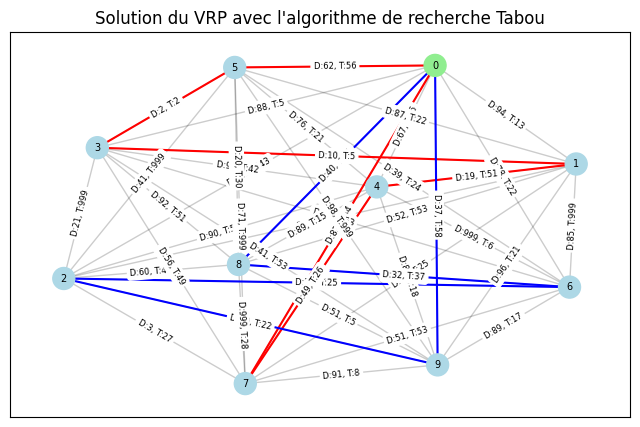

In [42]:
# Cette fonction retourne les routes et la distance totale minimale trouvées par la recherche tabou.
solution = tabu_VRP(G, K)

# Pour chaque tournée, elle affiche les nœuds visités et la distance parcourue.
print_solution(G, solution)

# Affiche le graphe avec les tournées optimales visualisées
draw_graph(G, solution, title="Solution du VRP avec l'algorithme de recherche Tabou")

## Resolution du problème grâce à la **l'algorithme de colonie de fourmis**

Cet algorithme simule le comportement de plusieurs fourmis virtuelles qui cherchent des chemins entre des points. Chaque fourmi construit une solution en suivant des règles guidées par des traces de phéromones et des choix aléatoires. Les meilleures solutions laissent plus de phéromones, ce qui influence les choix des prochaines fourmis. Le processus se répète plusieurs fois jusqu’à ce qu’un bon chemin soit trouvé ou qu’un nombre maximal d’itérations soit atteint.

In [ ]:
def ants_VRP(G, K, depot=0, num_ants=10, iterations=300, alpha=1, beta=2, evaporation_rate=0.5, pheromone_init=1.0):
    # Initialisation des phéromones sur chaque arête
    pheromones = {edge: pheromone_init for edge in G.edges}
    
    best_routes = None
    best_cost = float('inf')
    
    # Liste des nœuds sans le dépôt
    nodes = list(G.nodes)
    nodes.remove(depot)
    
    # Répartition approximative des clients par véhicule
    nodes_per_vehicle = len(nodes) // K
    extra_nodes = len(nodes) % K
    
    courantes = []              # Coût minimal trouvé à chaque itération
    meilleures_courantes = []   # Meilleur coût global trouvé jusqu'à chaque itération

    for iteration in range(iterations):
        iteration_best_cost = float('inf')  # Meilleur coût de cette itération

        for ant in range(num_ants):  # Pour chaque fourmi
            unvisited = set(G.nodes)
            unvisited.remove(depot)
            routes = []
            total_cost = 0

            for vehicle in range(K):
                current_route = [depot]
                current_node = depot
                visited_this_trip = set()
                
                # Nombre de clients à visiter pour ce véhicule
                nodes_to_visit = nodes_per_vehicle + (1 if vehicle < extra_nodes else 0)

                while unvisited and len(visited_this_trip) < nodes_to_visit:
                    neighbors = [n for n in G.neighbors(current_node) if n in unvisited]
                    if not neighbors:
                        break

                    probabilities = []
                    for neighbor in neighbors:
                        # Calcul de la probabilité en fonction des phéromones et de la distance
                        edge = (current_node, neighbor) if (current_node, neighbor) in pheromones else (neighbor, current_node)
                        pheromone = pheromones[edge]
                        distance = G[current_node][neighbor]['distance']
                        probabilities.append((neighbor, (pheromone ** alpha) * ((1 / distance) ** beta)))

                    if not probabilities:
                        break

                    total_prob = sum(prob[1] for prob in probabilities)
                    # Choix du prochain nœud en fonction des probabilités
                    next_node = random.choices(
                        [node for node, _ in probabilities],
                        [prob / total_prob for _, prob in probabilities]
                    )[0]

                    current_route.append(next_node)
                    total_cost += G[current_node][next_node]['distance']
                    unvisited.remove(next_node)
                    visited_this_trip.add(next_node)
                    current_node = next_node

                # Retour au dépôt à la fin de la tournée
                if current_node != depot:
                    current_route.append(depot)
                    total_cost += G[current_node][depot]['distance']

                routes.append(current_route)

            # Mise à jour du meilleur coût global et local
            if total_cost < best_cost:
                best_cost = total_cost
                best_routes = routes

            if total_cost < iteration_best_cost:
                iteration_best_cost = total_cost

        courantes.append(iteration_best_cost)
        meilleures_courantes.append(best_cost)

        # Évaporation des phéromones
        for edge in pheromones:
            pheromones[edge] *= (1 - evaporation_rate)

        # Renforcement des arêtes empruntées dans la meilleure solution trouvée
        for route in best_routes:
            for i in range(len(route) - 1):
                edge = (route[i], route[i + 1]) if (route[i], route[i + 1]) in pheromones else (route[i + 1], route[i])
                pheromones[edge] += 1 / best_cost

    # Conversion des routes en listes d'arêtes pour affichage
    formatted_routes = []
    for route in best_routes:
        edges = [(route[i], route[i + 1]) for i in range(len(route) - 1)]
        formatted_routes.append(edges)

    return formatted_routes


RÉSUMÉ GLOBAL
Distance totale : 353
Temps max       : 241

Camion      Distance     Temps   Tournée
-------------------------------------------------
0                193       241   0 → 9 → 2 → 7 → 6 → 8 → 0
1                160       150   0 → 4 → 1 → 3 → 5 → 0


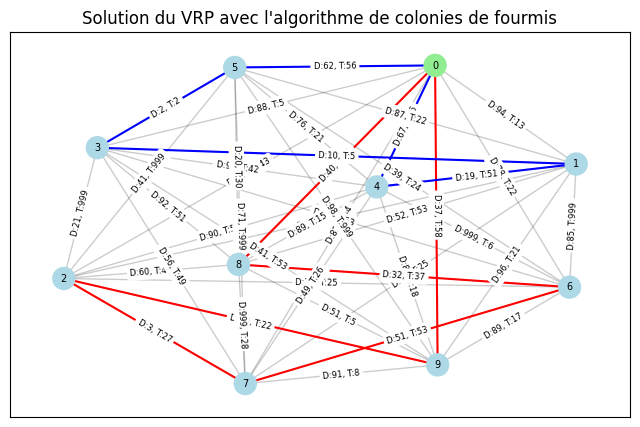

In [44]:
# Cette fonction retourne les routes et la distance totale minimale trouvées par l'algorithme de colonies de fourmis.
solution = ants_VRP(G, K)

# Pour chaque tournée, elle affiche les nœuds visités et la distance parcourue.
print_solution(G, solution)

# Affiche le graphe avec les tournées optimales visualisées
draw_graph(G, solution, title="Solution du VRP avec l'algorithme de colonies de fourmis")

## Exploitation des résultats

La fonction **run_algorithms_fixed_instance_size** permet de tester les 3 algorithmes différents sur plusieurs instances différentes d'une même taille

In [ ]:
def run_algorithms_fixed_instance_size(N=10, K=2, instances=10, with_pl=True):
    results = {
        'instance': [],
        'method': [],
        'distance': [],
        'time': []
    }

    for rep in range(instances):  # Répéter plusieurs fois pour chaque instance
        
        # Générer une graine unique pour chaque répétition
        seed = random.randint(0, 100000)
        random.seed(seed)
        G_test = generate_graph(N)

        print(f"Instance {rep + 1}/{instances}, Seed: {seed}")
        
        distance_pl = None
        time_pl = None

        # === Programmation Linéaire (PL) ===
        if with_pl:
            try:
                start_time = time.time()
                solution_pl = PL_VRP(G_test, K)
                distance_pl = sum(G_test.edges[u, v]['distance'] for edges in solution_pl for u, v in edges)
                time_pl = time.time() - start_time

                results['instance'].append(rep + 1)
                results['method'].append('PL')
                results['distance'].append(distance_pl)
                results['time'].append(time_pl)
            except:
                distance_pl = None
                time_pl = None

        # === Recherche Tabou ===
        try:
            start_time = time.time()
            solution_tabu = tabu_VRP(G_test, K)
            distance_tabu = sum(G_test.edges[u, v]['distance'] for edges in solution_tabu for u, v in edges)
            elapsed_time_tabu = time.time() - start_time

            results['instance'].append(rep + 1)
            results['method'].append('Tabou')
            results['distance'].append(distance_tabu)
            results['time'].append(elapsed_time_tabu)
        except:
            pass

        # === Colonie de Fourmis ===
        try:
            start_time = time.time()
            solution_ants = ants_VRP(G_test, K)
            distance_ants = sum(G_test.edges[u, v]['distance'] for edges in solution_ants for u, v in edges)
            elapsed_time_ants = time.time() - start_time

            results['instance'].append(rep + 1)
            results['method'].append('Fourmis')
            results['distance'].append(distance_ants)
            results['time'].append(elapsed_time_ants)
        except:
            pass

    # Organisation des résultats dans un DataFrame
    df_results = pd.DataFrame(results)

    # Calcul des écarts uniquement si PL est présent
    differences = []
    if with_pl:
        for instance in df_results['instance'].unique():
            pl_row = df_results[(df_results['instance'] == instance) & (df_results['method'] == 'PL')]
            for method in ['Tabou', 'Fourmis']:
                method_row = df_results[(df_results['instance'] == instance) & (df_results['method'] == method)]
                if not pl_row.empty and not method_row.empty:
                    diff_distance = method_row['distance'].values[0] - pl_row['distance'].values[0]
                    diff_time = method_row['time'].values[0] - pl_row['time'].values[0]
                    differences.append({
                        'instance': instance,
                        'method': method,
                        'diff_distance': diff_distance,
                        'diff_time': diff_time
                    })

    df_differences = pd.DataFrame(differences)

    return df_results, df_differences


On teste nos algorithmes avec des 10 graphes aléatoires de 10 sommets avec 2 vehicules 

Instance 1/10, Seed: 92771
Instance 2/10, Seed: 76676
Instance 3/10, Seed: 68700
Instance 4/10, Seed: 42422
Instance 5/10, Seed: 24268
Instance 6/10, Seed: 60097
Instance 7/10, Seed: 77607
Instance 8/10, Seed: 16906
Instance 9/10, Seed: 30914
Instance 10/10, Seed: 85884


Moyenne et écart type des distances et des temps pour chaque méthode :

         mean_distance  std_distance  mean_time  std_time
method                                                   
Fourmis          280.8     49.156892   0.519316  0.022699
PL               256.2     47.506257   2.977517  1.163420
Tabou            291.2     83.720169   0.291578  0.012594


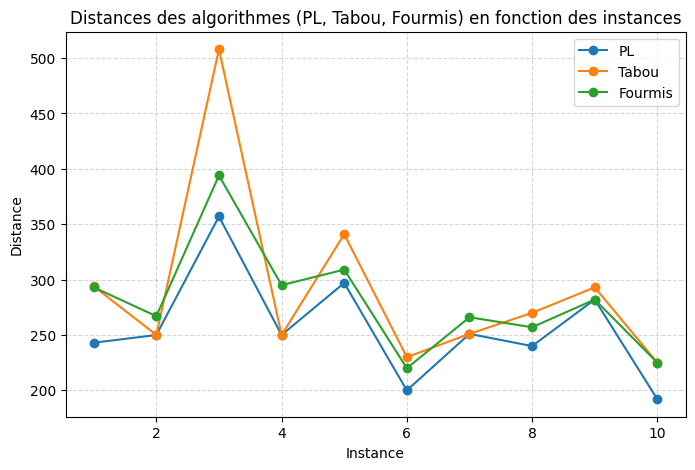


Moyenne et écart type des écarts (différences) entre PL et les méta-heuristiques :

         mean_diff_distance  std_diff_distance  mean_diff_time  std_diff_time
method                                                                       
Fourmis                24.6          15.910863       -2.458200       1.167600
Tabou                  35.0          44.842936       -2.685939       1.160413


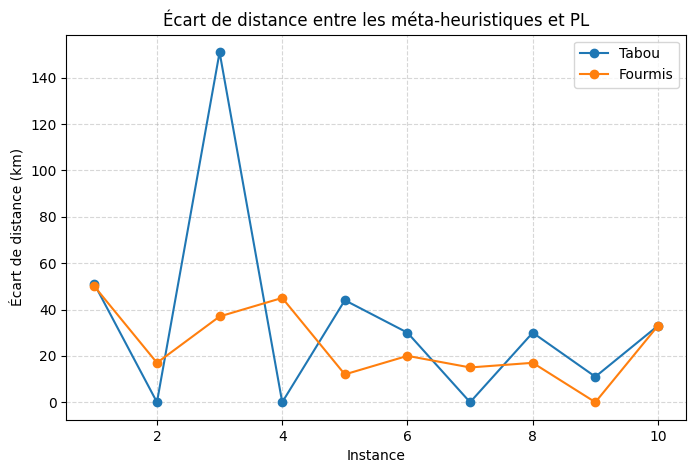

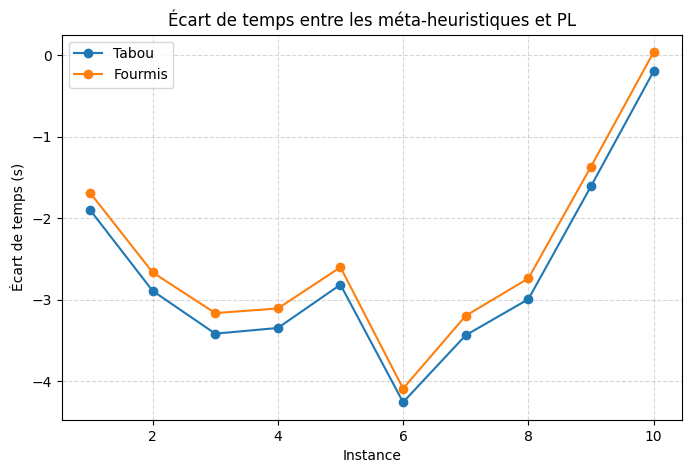

In [ ]:
df_results, df_differences = run_algorithms_fixed_instance_size(N=10, K=2, instances=10)

# Affichage des résultats
# --- Calcul des moyennes et écarts types --- #
print("\n\nMoyenne et écart type des distances et des temps pour chaque méthode :\n")
stats = df_results.groupby('method').agg(
    mean_distance=('distance', 'mean'),
    std_distance=('distance', 'std'),
    mean_time=('time', 'mean'),
    std_time=('time', 'std')
)
print(stats)

# --- Distances des algorithmes en fonction des instances --- #
plot_graph(df=df_results, methods=['PL', 'Tabou', 'Fourmis'], x_col='instance', y_col='distance', xlabel=f'Instance : {N} Sommets', ylabel='Distance', title='Distances des algorithmes (PL, Tabou, Fourmis) en fonction des instances')

# --- Moyenne et écart type des écarts (différences) --- #
print("\nMoyenne et écart type des écarts (différences) entre PL et les méta-heuristiques :\n")
diff_stats = df_differences.groupby('method').agg(
    mean_diff_distance=('diff_distance', 'mean'),
    std_diff_distance=('diff_distance', 'std'),
    mean_diff_time=('diff_time', 'mean'),
    std_diff_time=('diff_time', 'std')
)
print(diff_stats)

# --- Graphique : écart de distance --- #
plot_graph(df=df_differences, methods=['Tabou', 'Fourmis'], x_col='instance', y_col='diff_distance', xlabel=f'Instance : {N} Sommets', ylabel='Écart de distance (km)', title='Écart de distance entre les méta-heuristiques et PL')

# --- Graphique : écart de temps --- #
plot_graph(df=df_differences, methods=['Tabou', 'Fourmis'], x_col='instance', y_col='diff_time', xlabel=f'Instance : {N} Sommets', ylabel='Écart de temps (s)', title='Écart de temps entre les méta-heuristiques et PL')

La fonction **run_algorithms_variable_instance_size** permet de tester les 3 algorithmes plusieurs fois sur plusieurs instances ayant des tailles différentes. La taille des instances varie de $N_min$ à $N_max$ et il y a un nombre d'instance par taille définit par la variable $repetitions$.

In [ ]:
def run_algorithms_variable_instance_size(N_min=5, N_max=15, K=2, repetitions=10, with_pl=True):
    all_results = []        # Stocke tous les résultats détaillés
    all_differences = []    # Stocke tous les écarts
    
    for N in range(N_min, N_max + 1):
        print(f"\n=== Graphes de taille {N} ===")
        df_results, df_differences = run_algorithms_fixed_instance_size(N=N, K=K, instances=repetitions, with_pl=with_pl)

        # Ajouter la taille du graphe dans les DataFrames
        df_results['graph_size'] = N
        df_differences['graph_size'] = N

        # Afficher les résultats détaillés pour cette taille
        print("\nRésultats complets :")
        print(df_results)

        # Stocker tous les résultats pour résumé final
        all_results.append(df_results)
        all_differences.append(df_differences)

    # Fusion de toutes les données
    df_all_results = pd.concat(all_results, ignore_index=True)
    df_all_differences = pd.concat(all_differences, ignore_index=True)

    # Calcul des moyennes ET écarts-types pour distance et temps
    df_summary_results = df_all_results.groupby(['graph_size', 'method']).agg(
        mean_distance=('distance', 'mean'),
        std_distance=('distance', 'std'),
        mean_time=('time', 'mean'),
        std_time=('time', 'std')
    ).reset_index()

    # Calcul des moyennes ET écarts-types pour les différences
    if with_pl:
        df_summary_differences = df_all_differences.groupby(['graph_size', 'method']).agg(
            mean_diff_distance=('diff_distance', 'mean'),
            std_diff_distance=('diff_distance', 'std'),
            mean_diff_time=('diff_time', 'mean'),
            std_diff_time=('diff_time', 'std')
        ).reset_index()
    else:
        df_summary_differences = []
        
    return df_summary_results, df_summary_differences

On teste nos algorithmes avec des instances allant de 5 à 15 sommets avec 10 instances par taille pour tracer des graphiques de moyenne.

In [ ]:
df_results, df_differences = run_algorithms_variable_instance_size(N_min=5, N_max=15, K=2, repetitions=10)

print("\n\nMoyenne et écart type des distances et des temps pour chaque méthode :\n")
print(df_results)

print("\n\nMoyenne et écart type des écarts (différences) entre PL et les méta-heuristiques :\n")
print(df_differences)

# # Affichage des résultats
# --- Moyennes de distances des algorithmes en fonction de la taille des instances --- #
plot_graph(df=df_results, methods=['PL', 'Tabou', 'Fourmis'], x_col='graph_size', y_col='mean_distance', xlabel=f'Taille des instances', ylabel='Distance moyenne (km)', title='Distances des algorithmes (PL, Tabou, Fourmis) en fonction de la taille des instances', with_errorbar=True, error_col='std_distance')

# --- Ecarts moyens de distance entre PL et les méta-heuristiques en fonction de la taille des instances --- #
plot_graph(df=df_differences, methods=['Tabou', 'Fourmis'], x_col='graph_size', y_col='mean_diff_distance', xlabel=f'Taille des instances', ylabel='Écart moyen de distance avec PL', title='Écart moyen de distance avec PL en fonction du nombre de sommets')

On reteste seulement les metaheuristiques avec des instances de plus grande taille.

In [ ]:
df_results, df_differences = run_algorithms_variable_instance_size(N_min=5, N_max=30, K=2, repetitions=10, with_pl=False)

print("\n\nMoyenne et écart type des distances et des temps pour chaque méthode :\n")
print(df_results)

print("\n\nMoyenne et écart type des écarts (différences) entre PL et les méta-heuristiques :\n")
print(df_differences)

# # Affichage des résultats
# --- Moyennes de distances des algorithmes en fonction de la taille des instances --- #
plot_graph(df=df_results, methods=['Tabou', 'Fourmis'], x_col='graph_size', y_col='mean_distance', xlabel=f'Taille des instances', ylabel='Distance moyenne (km)', title='Distances des algorithmes (Tabou, Fourmis) en fonction de la taille des instances', with_errorbar=True, error_col='std_distance')

# --- Moyenne des temps des algorithmes en fonction de la taille des instances --- #
plot_graph(df=df_results, methods=['Tabou', 'Fourmis'], x_col='graph_size', y_col='mean_time', xlabel=f'Taille des instances', ylabel='Temps moyen (s)', title='Temps des algorithmes (Tabou, Fourmis) en fonction de la taille des instances', with_errorbar=True, error_col='std_time')